In [ ]:
library(pheatmap)
library(dplyr)
library(tidyverse)
library(ggplot2)
library(RColorBrewer)
library(MetBrewer)


In [ ]:
# Read in and tidying data
dir <- 'RF_heatmap/'
tail <- '.tsv'
morphogens <- c('RA_BMP4', 'RA_SHH', 'CHIR_BMP4')

df_list <- list()

for(i in seq_along(morphogens)){
    df_list[[i]] <- read.table(paste0(dir, morphogens[i], tail),
                               sep='\t', header=TRUE)
    rownames(df_list[[i]]) <- df_list[[i]]$X
    df_list[[i]]$X <- NULL
}

names(df_list) <- morphogens


In [6]:
# Setting colors for plotting
my_colour = list(
    AP_axis = c(XAV_3 = "#9a133d", XAV_2 = "#d8527c", XAV_1 = "#f9b4c9", ctrl='grey90',
               CHIR_1 = "#dec5da", CHIR_2 = "#b695bc", CHIR_3 = "#90719f", CHIR_4 = "#574571",
               RA_4 = "#376795", RA_3 = "#528fad", RA_2 = "#72bcd5", RA_1 = "#aadce0",
               FGF8_1 = "plum1", FGF8_2 = "orchid2", FGF8_3 = "mediumorchid3", FGF8_4 = "magenta4",
               RA_4_CHIR = "#3c7c3d", RA_3_CHIR = "#669d62", 
               RA_2_CHIR = "#9cc184", RA_1_CHIR = "#c2d6a4",
               FGF8_1_CHIR = "gray80", FGF8_2_CHIR = "gray60",
               FGF8_3_CHIR = "gray40", FGF8_4_CHIR = "gray20"),
    
    DV_axis = c(BMP4_3 = "#ffb242", BMP4_2 = "#ffd353", BMP4_1 = '#ffe6b7',
               ctrl = 'grey90', SHH_1 = '#C2D9F7', SHH_2 = "#98C1F0",
               SHH_3 = "#4782DD", SHH_4 = "#1D52A1")
)


In [9]:
# Create dataframe for sidebar plotting
# Setting up lists for storing data

sidebar_info <- list()

sidebar_info[[1]] <- data.frame(
    pairs = colnames(df_list[[1]]),
    AP_axis = c(rep('ctrl', times = 4), rep('RA_1', times = 4), rep('RA_2', times = 4), rep('RA_3', times = 4), rep('RA_4', times = 4)),
    DV_axis = rep(c('ctrl', 'BMP4_1', 'BMP4_2', 'BMP4_3'), times=5)
)

sidebar_info[[2]] <- data.frame(
    pairs = colnames(df_list[[2]]),
    AP_axis = c(rep('ctrl', times = 5), rep('RA_1', times = 5), rep('RA_2', times = 5), rep('RA_3', times = 5), rep('RA_4', times = 5)),
    DV_axis = rep(c('ctrl', 'SHH_1', 'SHH_2', 'SHH_3', 'SHH_4'), times=5)
)

sidebar_info[[3]] <- data.frame(
    pairs = colnames(df_list[[3]]),
    AP_axis = c(rep('ctrl', times = 4), rep('CHIR_1', times = 4), rep('CHIR_2', times = 4), rep('CHIR_3', times = 4), rep('CHIR_4', times = 4)),
    DV_axis = rep(c('ctrl', 'BMP4_1', 'BMP4_2', 'BMP4_3'), times=5)
)

names(sidebar_info) <- morphogens


In [14]:
# Setting up rownames for sidebar_info to enable plotting

for(i in seq_along(morphogens)){
    rownames(sidebar_info[[i]]) <- sidebar_info[[i]]$pairs
}


In [ ]:
# Read in tf lists
tf <- read.table('allTFs_hg38.txt',
                       sep='\t')
head(tf$V1)


[1] "ZNF354C" "KLF12"   "ZNF143"  "ZIC2"    "ZNF274"  "SP2"

In [ ]:
# Filtering goi_list for tf
goi_tf_list <- list()

for(i in seq_along(morphogens)){
    goi_tf_list[[i]] <- goi_list[[i]][names(goi_list[[i]]) %in% tf$V1]
}

names(goi_tf_list) <- morphogens

In [38]:
library(grid)
### Function to add flag
# Source: https://github.com/weshorton/miscTools/blob/master/addFlagsPheatmap.R

#### TO DO!!!!
#### STILL NEED TO CHECK OUT THE GROUPING ARGUMENTS. NGRP_V = 1 AND NGRP_V = 2 appear to be the same....

addFlag <- function(pheatmap,
                    labels_v,
                    offset_v = 0.3,
                    repelDegree_v,
                    nGrp_v = 1) {
  #' Add special labels to pheatmap
  #' @description Add labels with flags to select rows of a heatmap
  #' @param pheatmap pheatmap object
  #' @param labels_v vector of labels to include
  #' @param offset_v numeric vector indicating how much to offset labels to the left (Default is 0.3)
  #' @param repelDegree_v value between 0 and 1 that controls space to allocate for label repel.
  #' repel.degree = 0: spread out labels over existing range of kept labels
  #' repel.degree = 1: spread out labels of full y-axis
  #' @param nGrp_v numeric value to set the number of groups of flags. Flags within a group will be equidistant from each other
  #' @details Function provided by Z.Lin here https://stackoverflow.com/questions/52599180/partial-row-labels-heatmap-r
  #' @value pheatmap object
  #' @export
  
  ## Grab heatmap gtable
  heat_gtable <- pheatmap$gtable
  
  ## Extract row names grob
  label_grob <- heat_gtable$grobs[[which(heat_gtable$layout$name == "row_names")]]
  
  ## Replace all labels not found in labels_v with ''
  label_grob$label <- ifelse(label_grob$label %in% labels_v, label_grob$label, "")
  
  ## If there are more than 40 rows, space labels out by adding flags
  if (length(label_grob$label) > 40) {
    
    ## Calculate new y positions
    newY_v <- repelledY(d = label_grob$y,
                        d.select = label_grob$label != "",
                        k = repelDegree_v,
                        n = nGrp_v)
    
    ## Create new grob for the flag line segments
    newFlag_grob <- segmentsGrob(x0 = label_grob$x - unit(0.05, "npc"),
                                 x1 = label_grob$x + unit((offset_v*.85), "npc"),
                                 y0 = label_grob$y[label_grob$label != ""],
                                 y1 = newY_v)
    
    ## Shift selected labels to the right to make room for line segments
    label_grob$x <- label_grob$x + unit(offset_v, "npc")
    
    ## Change y positions of selected labels
    label_grob$y[label_grob$label != ""] <- newY_v
    
    ## Add flag line segment grob to heatmap
    heat_gtable <- gtable::gtable_add_grob(x = heat_gtable,
                                           grobs = newFlag_grob,
                                           t = 4, l = 4)
  } # fi
  
  ## Replace label grob with
    ## nrow(heatmap) > 40: selected labels only, spaced evenly and with flags added
    ## nrow(heatmap) <= 40: selected labels only, with same y positioning
  heat_gtable$grobs[[which(heat_gtable$layout$name == "row_names")]] <- label_grob
  
  ## plot result
  grid.newpage()
  grid.draw(heat_gtable)
  
  ## Return copy invisibly
  invisible(heat_gtable)
}


### New repelledy Y
repelledY <- function(d, d.select, k = repelDegree_v, n = nGrp_v){
  #' Calculate y positioning
  #' @description Calculate evenly-spaced heatmap label y positions
  #' @param d vector of distances for labels (usually $y element of label_grob)
  #' @param d.select vector of T/F for which labels are significant (i.e. to be plotted)
  #' @param k repelDegree_v
  #' @param n nGrp_v
  #' @export
  
  ## Get full y-axis range of points
  fullYRange_v <- sapply(seq_along(d), function(i) as.numeric(convertX(d[i], "npc")))
  
  ## Subset for just the labeled ones
  selectYRange_v <- sapply(seq_along(d[d.select]), function(i) as.numeric(convertX(d[d.select][i], "npc")))
  
  ## Split select range
  chunks <- function(x, l) split(x, cut(seq_along(x), l, labels = F))
  if (n >= 2) {
    selectYRange_lsv <- chunks(selectYRange_v, n)
  } else {
    selectYRange_lsv <- list(selectYRange_v)
  }
  
  ## Get final values for each range - to do - make this work with repelDegree_v
  allFinal_lsv <- list()
  for (i in 1:length(selectYRange_lsv)) {
    currSelect_v <- selectYRange_lsv[[i]]
    currSmin_v <- min(currSelect_v); currSmax_v <- max(currSelect_v)
    # currFullMax_v <- max(fullYRange_v[fullYRange_v >= currSmax_v])
    # currFullMin_v <- min(fullYRange_v[fullYRange_v < currSmin_v])
    # currFinal_v <- unit(seq(from = currSmax_v + k * (currFullMax_v = currSmax_v),
    #                         to = currSmin_v - k * (currSmin_v - currFullMin_v),
    #                         length.out = length(currSelect_v)), "npc")
    currFinal_v <- unit(seq(from = currSmax_v, to = currSmin_v, length.out = length(currSelect_v)), "npc")
    allFinal_lsv[[i]] <- currFinal_v
  } # for i
  
  ## Change to npc
  allFinal_v <- unit(unlist(allFinal_lsv), "npc")
  
  ## Return
  return(allFinal_v)
} # repelledY


### Original repelledY Function with strip.npc
origRepelledY <- function(d, d.select, k = repelDegree_v){
  #' Calculate y positioning
  #' @description Calculate evenly-spaced heatmap label y positions
  #' @param d vector of distances for labels (usually $y element of label_grob)
  #' @param d.select vector of T/F for which labels are significant (i.e. to be plotted)
  #' @param k repelDegree_v
  #' @export
  
  ## Get current label positions (recursive)
  ## Unit is 'npc'
  strip.npc <- function(dd){
    if(!"unit.arithmetic" %in% class(dd)) {
      return(as.numeric(dd))
    } # fi
    
    d1 <- strip.npc(dd$arg1)
    d2 <- strip.npc(dd$arg2)
    fn <- dd$fname
    return(lazyeval::lazy_eval(paste(d1, fn, d2)))
  } # strip.npc
  
  ## Get full y-axis range of points
  fullYRange_v <- sapply(seq_along(d), function(i) strip.npc(d[i]))
  
  ## Subset for chosen k/repelDegree_v
  selectYRange_v <- sapply(seq_along(d[d.select]), function(i) strip.npc(d[d.select][i]))
  
  ## Get final values spaced by k
  finalVals_v <- unit(seq(from = max(selectYRange_v) + k*(max(fullYRange_v) - max(selectYRange_v)),
                          to = min(selectYRange_v) - k*(min(selectYRange_v) - min(fullYRange_v)),
                          length.out = sum(d.select)), "npc")
  ## Return
  return(finalVals_v)
} # repelledY



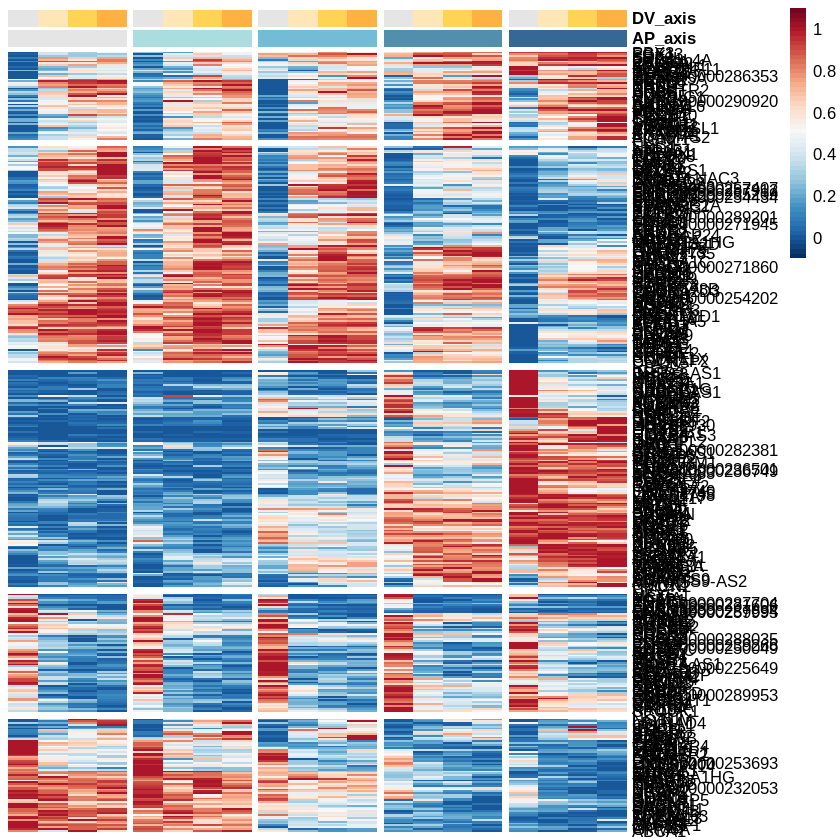

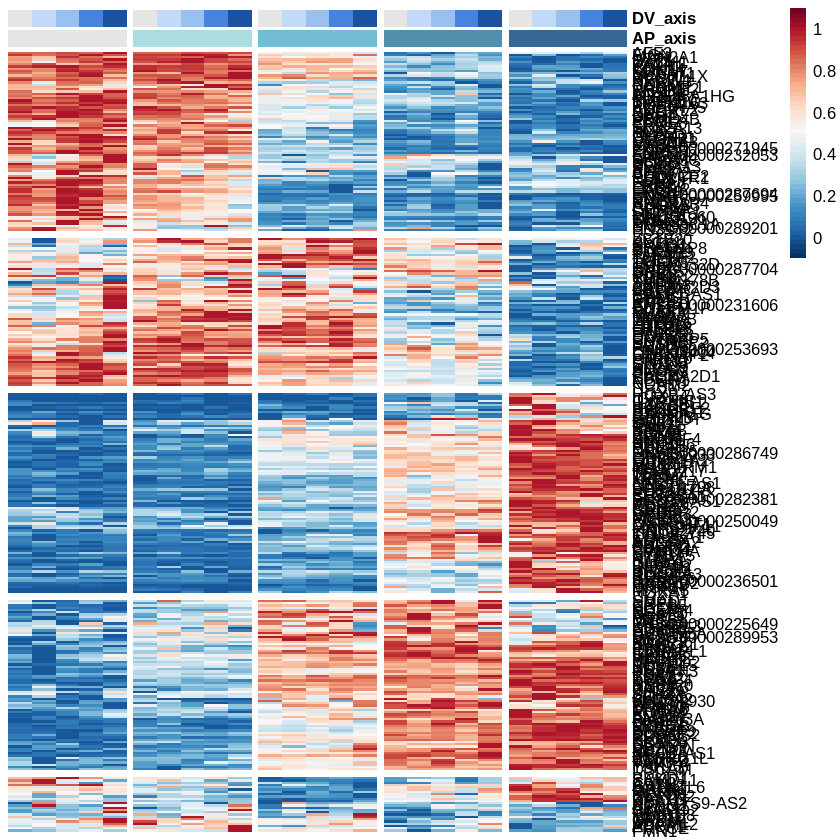

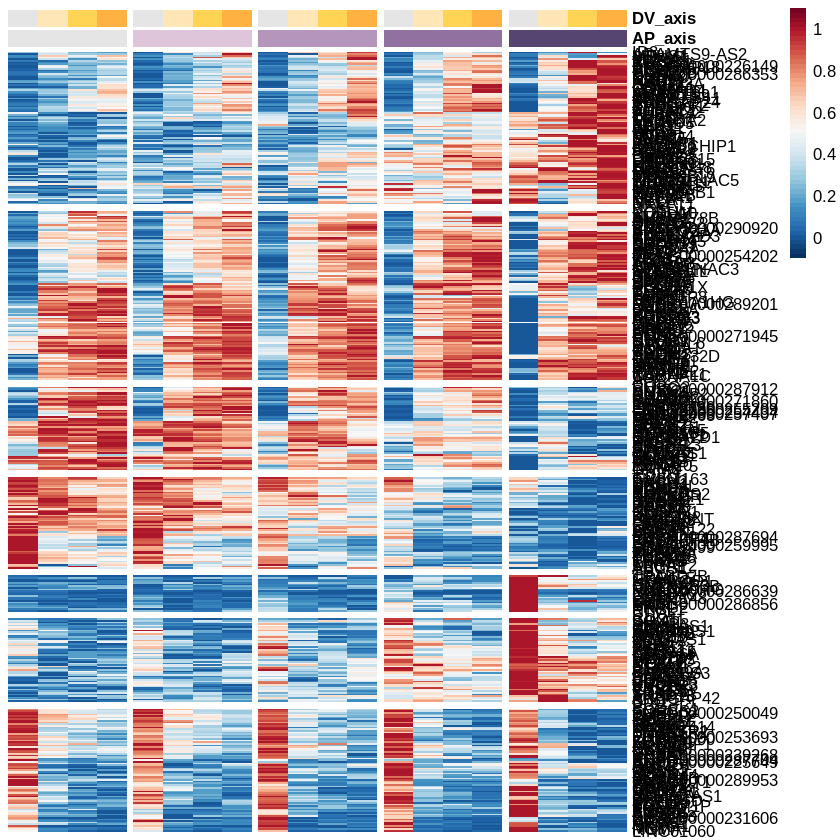

In [ ]:
# Set up list for pheatmap output

out_list <- list()

out_list[[1]] <- pheatmap(df_list[[1]], 
         breaks = seq(-0.1, 1.1, length.out = 55),
         color=colorRampPalette(rev(brewer.pal(n = 11, name = "RdBu")))(55),
         gaps_col = c(4, 8, 12, 16),
         annotation_col=sidebar_info[[1]][,2:3],
         annotation_colors = my_colour, 
         cutree_rows = 5,
         treeheight_row = 0,
         show_colnames = FALSE,
         annotation_legend = FALSE,
         cluster_cols=FALSE)

out_list[[2]] <- pheatmap(df_list[[2]], 
         breaks = seq(-0.1, 1.1, length.out = 55),
         color=colorRampPalette(rev(brewer.pal(n = 11, name = "RdBu")))(55),
         gaps_col = c(5, 10, 15, 20),
         annotation_col=sidebar_info[[2]][,2:3],
         annotation_colors = my_colour, 
         cutree_rows = 5,
         treeheight_row = 0,
         show_colnames = FALSE,
         annotation_legend = FALSE,
         cluster_cols=FALSE) 

out_list[[3]] <- pheatmap(df_list[[3]], 
         breaks = seq(-0.1, 1.1, length.out = 55),
         color=colorRampPalette(rev(brewer.pal(n = 11, name = "RdBu")))(55),
         gaps_col = c(4, 8, 12, 16),
         annotation_col=sidebar_info[[3]][,2:3],
         annotation_colors = my_colour, 
         cutree_rows = 7,
         treeheight_row = 0,
         show_colnames = FALSE,
         annotation_legend = FALSE,
         cluster_cols=FALSE)

names(out_list) <- morphogens


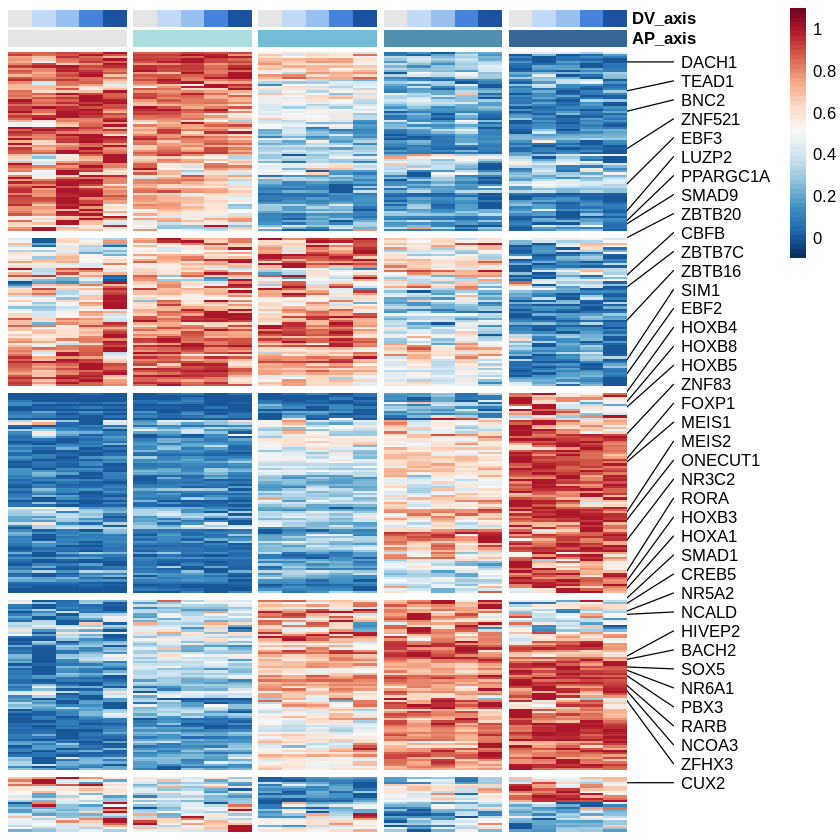

In [41]:
options(repr.plot.width=7, repr.plot.height=7)
addFlag(out_list[[2]], names(goi_tf_list[[2]]), offset_v = 0.3, 1, nGrp_v=1)


In [ ]:
pdf("RF_regress_RA_SHH_TFlabel.pdf", height=10, width=10)
addFlag(out_list[[2]], names(goi_tf_list[[2]]), offset_v = 0.3, 1, nGrp_v=1)
dev.off()

pdf("RF_regress_CHIR_BMP4_TFlabel.pdf", height=10, width=10)
addFlag(out_list[[3]], names(goi_tf_list[[3]]), offset_v = 0.3, 1, nGrp_v=1)
dev.off()


png 
  2

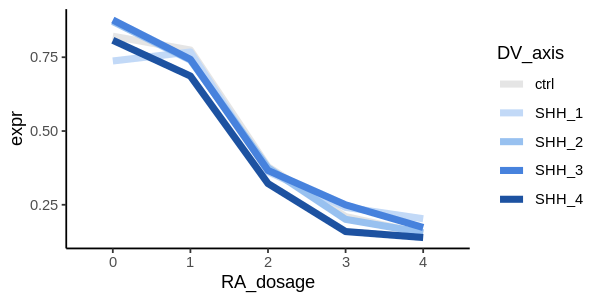

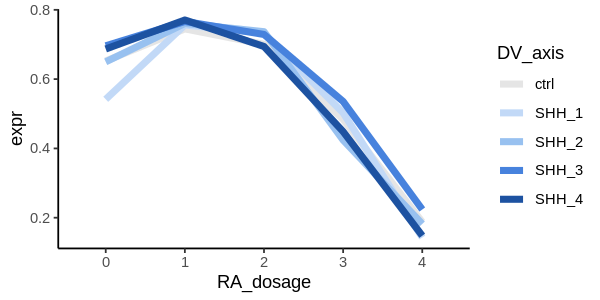

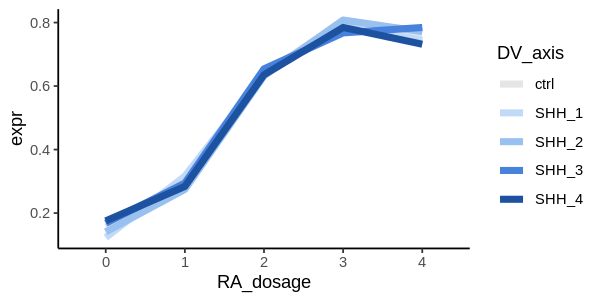

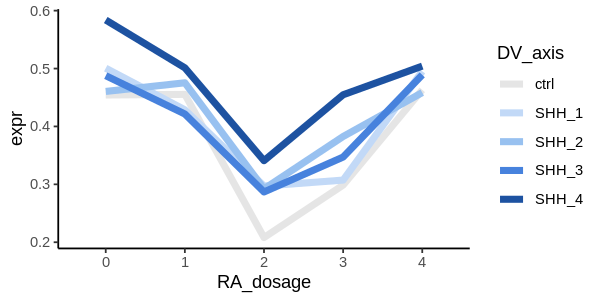

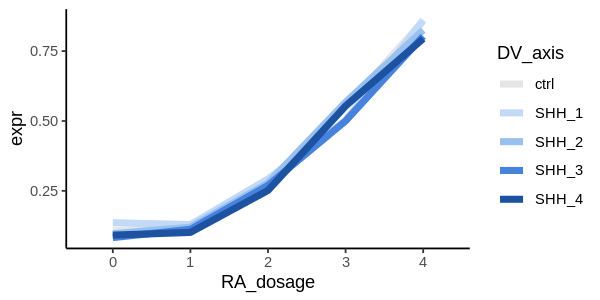

In [ ]:
# Systematic plotting of gene expression dosage responses
options(repr.plot.width=5, repr.plot.height=2.5)

x=2

dir <- 'RA_SHH_label/RA_SHH_'
tail <- '.pdf'

for(i in 1:5){
df_plot <- cbind(sidebar_info[[x]], as.data.frame(colMeans(df_list[[x]][names(goi_list[[x]][goi_list[[x]] == i]),])))

df_plot$RA_dosage <- plyr::mapvalues(
    df_plot$AP_axis,
    from = c('ctrl', 'RA_1', 'RA_2', 'RA_3', 'RA_4'),
    to = c(0, 1, 2, 3, 4)
)

names(df_plot) <- c('pairs', 'AP_axis', 'DV_axis', 'expr', 'RA_dosage')

# Reorder DV_axis
df_plot$DV_axis <- factor(df_plot$DV_axis, 
                          levels=c('ctrl', 'SHH_1', 'SHH_2', 'SHH_3', 'SHH_4'))

# Plot
p <- ggplot(df_plot, aes(x=RA_dosage, y=expr, group=DV_axis)) +
    geom_line(aes(color=DV_axis), linewidth=2) +
    scale_color_manual(values=c("grey90", "#C2D9F7", "#98C1F0", '#4782DD', '#1D52A1')) +
    theme_classic()

print(p)
ggsave(paste0(dir, i, tail), width=12, height=6, unit='cm')
    
}


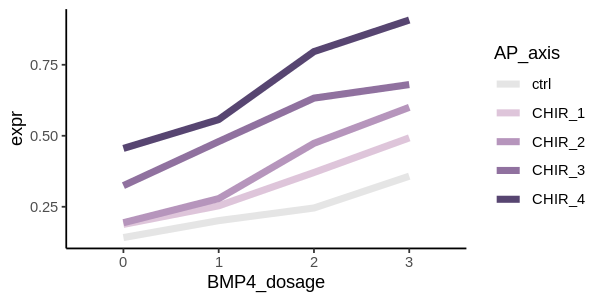

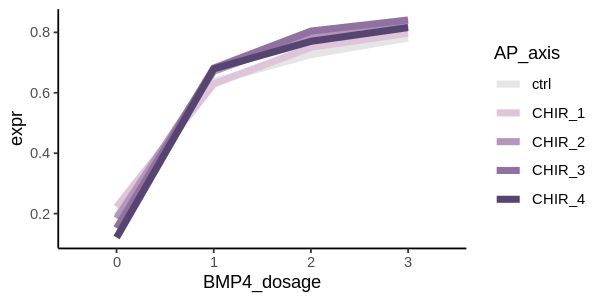

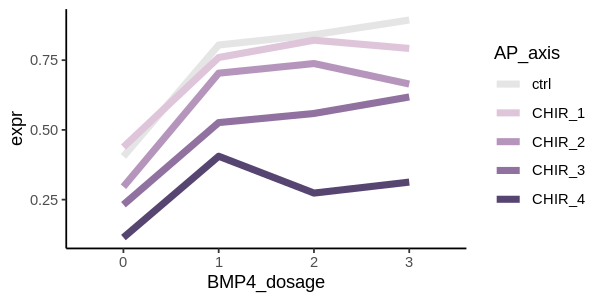

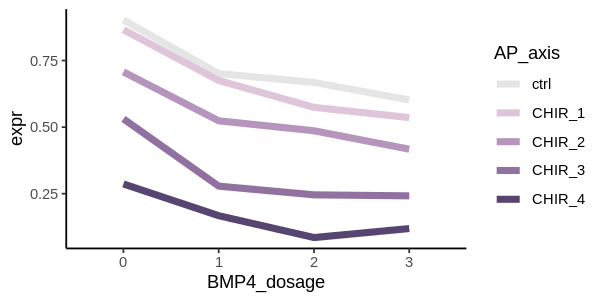

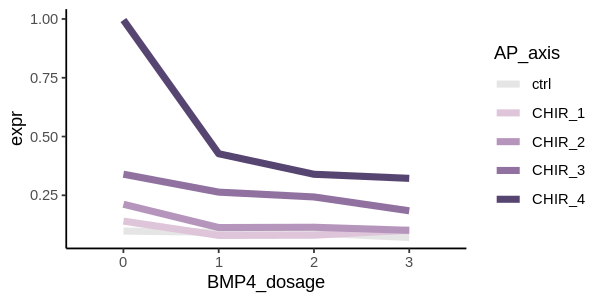

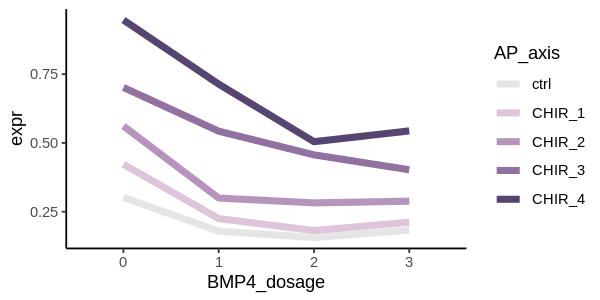

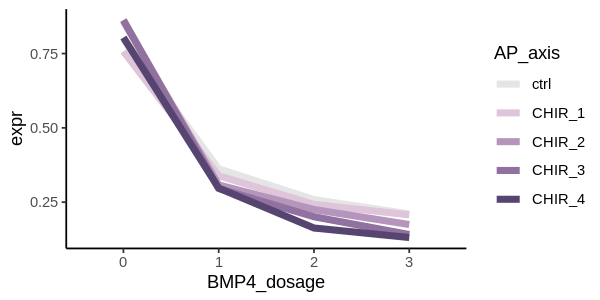

In [ ]:
# Systematic plotting of gene expression dosage responses
options(repr.plot.width=5, repr.plot.height=2.5)

x=3

dir <- 'CHIR_BMP4_label/CHIR_BMP4_'
tail <- '.pdf'

for(i in 1:7){
df_plot <- cbind(sidebar_info[[x]], as.data.frame(colMeans(df_list[[x]][names(goi_list[[x]][goi_list[[x]] == i]),])))

df_plot$BMP4_dosage <- plyr::mapvalues(
    df_plot$DV_axis,
    from = c('ctrl', 'BMP4_1', 'BMP4_2', 'BMP4_3'),
    to = c(0, 1, 2, 3)
)

names(df_plot) <- c('pairs', 'AP_axis', 'DV_axis', 'expr', 'BMP4_dosage')

# Reorder DV_axis
df_plot$AP_axis <- factor(df_plot$AP_axis, 
                          levels=c('ctrl', 'CHIR_1', 'CHIR_2', 'CHIR_3', 'CHIR_4'))

# Plot
p <- ggplot(df_plot, aes(x=BMP4_dosage, y=expr, group=AP_axis)) +
    geom_line(aes(color=AP_axis), linewidth=2) +
    scale_color_manual(values=c("grey90", "#dec5da", "#b695bc", "#90719f", "#574571")) +
    theme_classic()

print(p)
#ggsave(paste0(dir, i, tail), width=12, height=6, unit='cm')
    
}


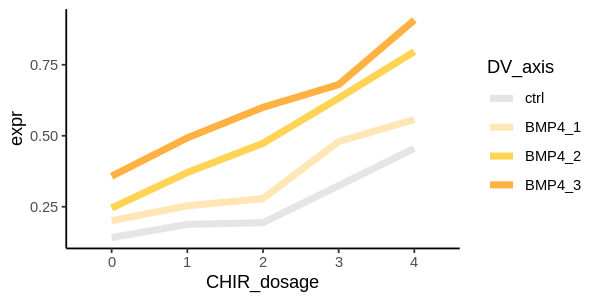

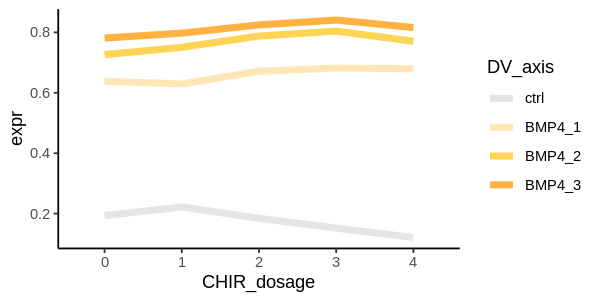

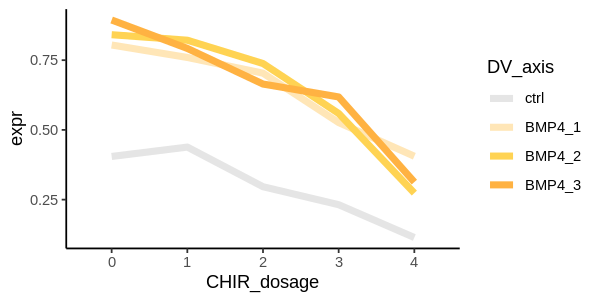

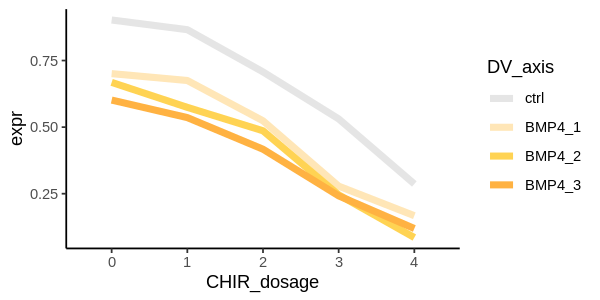

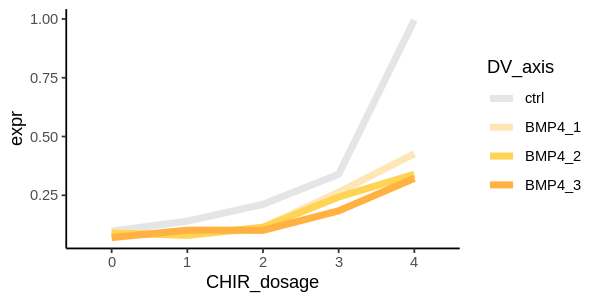

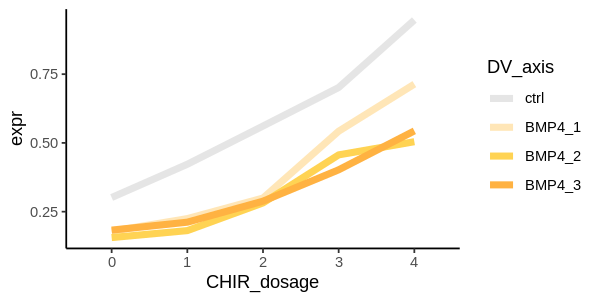

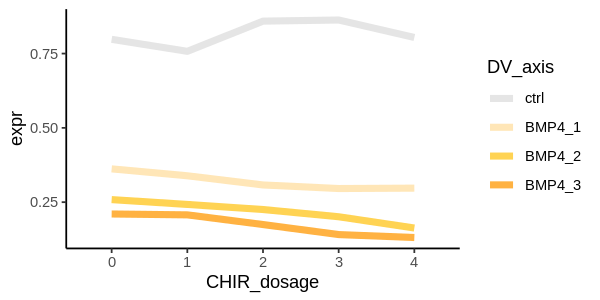

In [ ]:
# Systematic plotting of gene expression dosage responses
options(repr.plot.width=5, repr.plot.height=2.5)

x=3

dir <- 'CHIR_BMP4_label/CHIR_BMP4_'
tail <- '.pdf'

for(i in 1:7){
df_plot <- cbind(sidebar_info[[x]], as.data.frame(colMeans(df_list[[x]][names(goi_list[[x]][goi_list[[x]] == i]),])))

df_plot$CHIR_dosage <- plyr::mapvalues(
    df_plot$AP_axis,
    from = c('ctrl', 'CHIR_1', 'CHIR_2', 'CHIR_3', 'CHIR_4'),
    to = c(0, 1, 2, 3, 4)
)

names(df_plot) <- c('pairs', 'AP_axis', 'DV_axis', 'expr', 'CHIR_dosage')

# Reorder DV_axis
df_plot$DV_axis <- factor(df_plot$DV_axis, 
                          levels=c('ctrl', 'BMP4_1', 'BMP4_2', 'BMP4_3'))

# Plot
p <- ggplot(df_plot, aes(x=CHIR_dosage, y=expr, group=DV_axis)) +
    geom_line(aes(color=DV_axis), linewidth=2) +
    scale_color_manual(values=c("grey90", "#ffe6b7", "#ffd353", '#ffb242')) +
    theme_classic()

print(p)
ggsave(paste0(dir, i, tail), width=12, height=6, unit='cm')
    
}
